In [1]:
from tf_util_y import *
from DP import DataLoader
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook

In [2]:
x = DataLoader(data_name = "FFBC400_8_",mode = 'reg',p_day = 50,train_prob = 0.95)
dd = x(p_type="all")

In [3]:
X,Y = dd["X_tr"],dd["Y_tr"]

In [25]:
class model2(MODEL):
    def __init__(self,**args):
        try:
            name = args["name"]
        except:
            name = "def_model2"
        MODEL.__init__(self,name)
                
        self.X = tf.placeholder(shape = [None,50,50,15],dtype=tf.float32) 
        self.Y = tf.placeholder(shape = [None,3],dtype=tf.float32) 
        
        self.BNX = BN(self.X,name = self.name + "BNX")
        self.Z1 = CONV2D(self.BNX,[5,5,15,16],name = self.name+"Z1")
        self.A1 = ACT_S(PLUSB(self.Z1,name=self.name+"b1"),name = self.name+"A1")
        self.Z2 = CONV2D(self.A1,[5,5,16,17],name = self.name+"Z2")
        self.A2 = ACT_S(PLUSB(self.Z2,name=self.name+"b2"),name = self.name+"A2")
        self.Z3_1 = CONV2D(self.A2,[5,5,17,17],name = self.name+"Z3_1",padding = "SAME")
        self.A3_1 = ACT(PLUSB(self.Z3_1,name=self.name+"b3_1"),name = self.name+"A3_1")
        self.P3_1 = tf.nn.max_pool(self.A3_1,strides=[1,6,6,1],ksize=[1,6,6,1],padding = "VALID")
        self.Z4_2 = CONV2D(self.P3_1,[3,3,17,10],name = self.name+"Z4_2",padding = "SAME")
        self.BNZ4_2 = BN(self.Z4_2,name = self.name+"BNZ4_2")
        self.ZS2 = CONV2D(self.BNZ4_2,[3,3,10,5],name = self.name+"ZS2")
        self.AS2 = tf.nn.relu(PLUSB(self.ZS2,name = self.name+"ZS2"))
        self.WS0 = tf.get_variable(self.name+"WS0",shape = [1], initializer= tf.contrib.layers.xavier_initializer())
        self.WS1 = tf.get_variable(self.name+"WS1",shape = [1], initializer= tf.contrib.layers.xavier_initializer())
        self.WS2 = tf.get_variable(self.name+"WS2",shape = [1], initializer= tf.contrib.layers.xavier_initializer())
        
        self.P3_2 = tf.nn.avg_pool(self.A2,strides=[1,6,6,1],ksize=[1,6,6,1],padding="VALID")
        self.Z3_2 = CONV2D(self.P3_2,[5,5,17,17],name=self.name+"Z3_2",padding="SAME")
        self.A3_2 = tf.nn.relu(PLUSB(self.Z3_2,name=self.name+"B3_2"))
        
        self.S1 = tf.concat([self.P3_1,self.A3_2],axis = 3)
        self.Z5 = CONV2D(self.S1,[3,3,34,30],name = self.name+"Z5")
        self.A6 = tf.nn.relu(PLUSB(self.Z5,name=self.name+"b5"))
        self.Z7 = CONV2D(self.A6,[1,1,30,5],name = self.name+"Z7")
        
        self.Z4_1 = CONV2D(self.A3_2,[3,3,17,10],name=self.name+"Z4_1",padding="SAME")
        self.BNZ4_1 = BN(self.Z4_1,name = self.name+"BNZ4_1")
        self.ZS1 = CONV2D(self.BNZ4_1,[3,3,10,5],name = self.name+"ZS1")
        self.AS1 = tf.nn.relu(PLUSB(self.ZS1,name=self.name+"bAS1"))
        
        self.R1 = self.Z7*self.WS0 + self.AS1*self.WS1 + self.AS2*self.WS2
        self.F1 = tf.contrib.layers.flatten(self.R1)
        
        self.WF = tf.get_variable(self.name+"WF",shape=[125,3],initializer=tf.contrib.layers.xavier_initializer())
        
        self.OUP = tf.matmul(self.F1,self.WF)
        self.cost = tf.reduce_max(tf.squared_difference(100*self.OUP[:,0],100*self.Y[:,0]))
        self.opt = tf.train.AdamOptimizer(0.1).minimize(self.cost)

In [26]:
tf.reset_default_graph()
m2 = model2()

In [27]:
m2.open()
m2.sess.run(tf.global_variables_initializer())

In [24]:
m2.close()

<IPython.core.display.Javascript object>


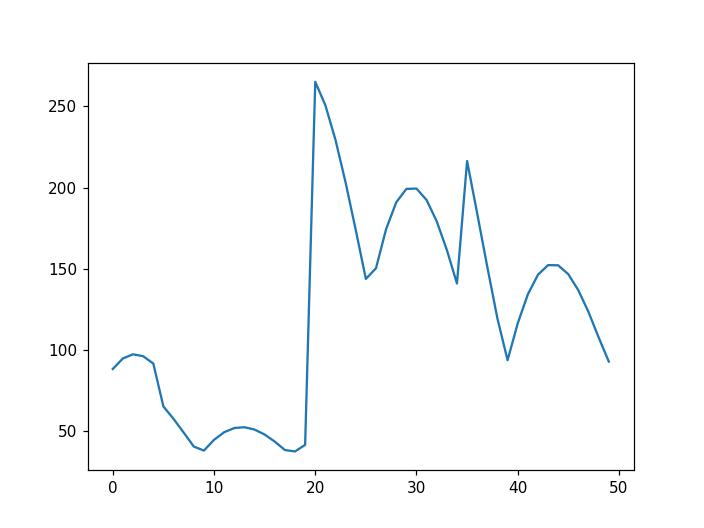

In [40]:
m2.train_minib(X,Y,bsize=128,bloop = 15,loop=60)

In [9]:
m2.sess.run(m2.OUP,feed_dict={m2.X:X[1:3,:,:,:]})

array([[ nan,  nan,  nan],
       [ nan,  nan,  nan]], dtype=float32)

In [23]:
from functools import reduce
def count_params():
    size = lambda v: reduce(lambda x, y: x*y, v.get_shape().as_list())
    n = sum(size(v) for v in tf.global_variables())
    print ("Model size: %dK" % (n/1000,))
    return n

In [29]:
XT,YT = dd["X_te"],dd["Y_te"]

In [41]:
yt = m2.sess.run(m2.OUP,feed_dict={m2.X:XT})

In [42]:
abs((YT[:,0]-yt[:,0])).max()

0.12114179889441166